#### Uncertainty of convective precipitation retrievals from Ka-band space-borne radar observations

**Issues**
* Severe attenuation, signal loss in the bottom portion of the profiles
* Retrievals depend on the *"a priori"* assumptions
* The objective function associated with the retrieval problem is highly non-linear and difficult to optimize.  Gauss-Newton may not converge or converge to a local minimum.  Global optimization approaches exist, but they are usually time-consuming.
* Initial solution is very important.

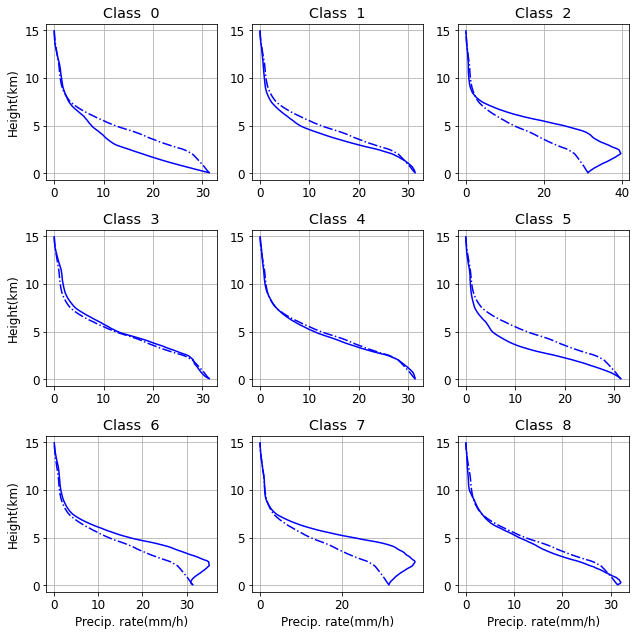

In [1]:
import numpy as np
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import matplotlib.colors as col
import matplotlib

fh=Dataset("simulatedObs_SAM.nc")

from sklearn.cluster import KMeans

zKa=fh["zKa_obs"][:]
zKa_true=fh["zKa_true"][:]
attKa=fh["attKa"][:]
tbL=fh["tb35"][:]
xL=fh["xL"][:]
piaKa=fh["piaKa"][:]
zKa0=zKa
zKa0[zKa0<0]=0
pRate=fh["pRate"][:]

a=np.nonzero(zKa_true[:,50]>0)
pZ_snow=np.polyfit(np.log(pRate[a[0],50]),zKa_true[a[0],50],1)
att_snow=np.polyfit(np.log(pRate[a[0],50]),np.log(attKa[a[0],50]),1)
pZ_rain=np.polyfit(np.log(pRate[a[0],0]),zKa_true[a[0],0],1)
att_rain=np.polyfit(np.log(pRate[a[0],0]),np.log(attKa[a[0],0]),1)
h=125/2.+np.arange(150)*125

fint=np.interp(range(150),[0,35,40,150],[1,1,0,0])
zL=[]
dr=0.125
for i,pRate1 in enumerate(pRate[:,:]):
    snowRate=(1-fint)*pRate1
    zSnow=pZ_snow[0]*np.log(snowRate+1e-3)+pZ_snow[1]
    attSnow=np.exp(att_snow[0]*np.log(snowRate+1e-3)+att_snow[1])
    rainRate=fint*pRate1
    zRain=pZ_rain[0]*np.log(rainRate+1e-3)+pZ_rain[1]
    zTot=10*np.log10(10**(0.1*zSnow)+10**(0.1*zRain))
    attRain=np.exp(att_rain[0]*np.log(rainRate+1e-3)+att_rain[1])
    attTot=(attSnow+attRain)*2*dr
    pia=attTot[::-1].cumsum()[::-1]
    zTot-=pia
    zL.append(zTot)

zL=np.array(zL)
from sklearn.model_selection import train_test_split

ind=range(zKa.shape[0])
ind_train, ind_test, \
    y_train, y_test \
    = train_test_split(ind, pRate[:,0], \
                       test_size=0.25, random_state=42)

from sklearn.cluster import KMeans
import matplotlib

matplotlib.rcParams.update({'font.size': 12})

kmeans = KMeans(n_clusters=9, random_state=0).fit(pRate[ind_train,:120])
plt.figure(figsize=(9,9))
pRateM=[]
pRatem=pRate[ind_train,:120].mean(axis=0)
for i in range(9):
    a=np.nonzero(kmeans.labels_==i)
    plt.subplot(3,3,i+1)
    p1=pRate[ind_train,:120][a[0],:].mean(axis=0)
    pRateM.append(p1*pRatem[0]/p1[0])
    plt.plot(p1*pRatem[0]/p1[0],h[:120]/1000.,\
             color='blue')
    plt.plot(pRatem,h[:120]/1000.,'-.',color='blue')
    if i%3==0:
        plt.ylabel('Height(km)')
    if i>=6:
        plt.xlabel('Precip. rate(mm/h)')
    plt.grid()
    plt.title('Class %2i'%i)
    plt.tight_layout()


In [2]:
import xarray as xr
zKaX=xr.DataArray(zKa)
zKa_trueX=xr.DataArray(zKa_true)
attKaX=xr.DataArray(attKa)
tbLX=xr.DataArray(tbL)
piaKaX=xr.DataArray(piaKa)
pRateX=xr.DataArray(pRate)
d=xr.Dataset({"zKa":zKaX,"zKa_true":zKa_trueX,"tbL":tbLX,"piaKa":piaKaX,"pRate":pRateX})
comp = dict(zlib=True, complevel=5)
encoding = {var: comp for var in ds.data_vars}
ds.to_netcdf(filename, encoding=encoding)